# LDPFL on the SVHN Dataset

This notebook shows how to run LDPFL on the SVHN Dataset.

#### Importing packages

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import LabelBinarizer
from Randomizer import LDPRandomizer as rz
from FL import FedMLFunc as fl
from FL import Net as Net
import torch, torch.nn as nn
from Helper import HelperFunctions as hf
import time
from tqdm import tqdm
rz = rz()
fl = fl()
hf = hf()

#### Main Configuration

In [2]:
np.random.seed(25)
num_classes = 10 

# Client training settings
localepochs = 50 # The number of epochs for local model training. 50 is the default value    
weight_decay = 1e-4

# FL settings
the_highest_num_clients = 100 # The highest number of clients tested. 
num_of_clients = 2  # The number of clients that are currently running
if num_of_clients > 2:
    num_selected = num_of_clients - 1 # The number of clients randomly selected (participate) in each round of FL
else:
    num_selected = num_of_clients
num_rounds = 200 # 400 is the default value
epochs = 50 # The number of epochs for the clients during FL 
batch_size = 32

#### Loading the data and normalizing the inputs

In [3]:
# The following data loading and normalization steps were 
# motivated by https://www.kaggle.com/code/dimitriosroussis/svhn-classification-with-cnn-keras-96-acc

# Load the data
train_raw = loadmat('./data/train_32x32.mat')
train_raw2 = loadmat('./data/extra_32x32.mat')
train_raw = dict(list(train_raw.items()) + list(train_raw2.items()))
test_raw = loadmat('./data/test_32x32.mat')

# Load images and labels
train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])
train_labels = train_raw['y']
test_labels = test_raw['y']

# Fix the axes of the images
train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

# Convert train and test images into 'float64' type
train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

# Convert train and test labels into 'int64' type
tr_labels = train_labels.astype('int64')
te_labels = test_labels.astype('int64')

# Normalize the image data
train_images /= 255.0
test_images /= 255.0

#### Preparation and partitioning of data for local training and randomization


In [4]:
# One-hot encoding of train and test labels
lb = LabelBinarizer()
train_labels = lb.fit_transform(tr_labels)
test_labels = lb.fit_transform(te_labels)

# Delare and initialize additional variables on training and testing data
Y_train = train_labels 
Y_test = test_labels

x_train_full = train_images
y_train_full = train_labels
x_test_full = test_images
y_test_full = test_labels

# Calculate the number of tuples that should be taken from the input dataset for training and testing
n_tup_client_tr = int(x_train_full.shape[0]/the_highest_num_clients)
tot_used_for_training = num_of_clients * n_tup_client_tr

n_tup_client_ts = int(x_test_full.shape[0]/the_highest_num_clients)
tot_used_for_testing = num_of_clients * n_tup_client_ts

# Trimming the full training and testing datasets based on the number of clients
x_train_full = train_images[0:tot_used_for_training]
y_train_full = Y_train[0:tot_used_for_training]
x_test_full = test_images[0:tot_used_for_testing]
y_test_full = Y_test[0:tot_used_for_testing]
 
# Generating training data partitions for training the model and generating randomized data
x_train_partitions = np.array_split(x_train_full, num_of_clients)
y_train_partitions = np.array_split(y_train_full, num_of_clients)

# Generating the testing data splits for the randomization of testing data
x_test_partitions = np.array_split(x_test_full, num_of_clients)

In [5]:
# Checking the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Getting information about the GPU usage before computation
if device.type == 'cuda':
    for i in range(0,torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
        print('Memory Usage of device :', i)
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Tesla P100-SXM2-16GB
Memory Usage of device : 0
Allocated: 0.0 GB
Cached:    0.0 GB
Tesla P100-SXM2-16GB
Memory Usage of device : 1
Allocated: 0.0 GB
Cached:    0.0 GB
Tesla P100-SXM2-16GB
Memory Usage of device : 2
Allocated: 0.0 GB
Cached:    0.0 GB
Tesla P100-SXM2-16GB
Memory Usage of device : 3
Allocated: 0.0 GB
Cached:    0.0 GB


#### Local model training and input randomization

In [6]:
r_x_train = []
r_x_test = []

for i in tqdm(range(0,num_of_clients)):
    client_inter_model = hf.client_model_create(i, x_train_partitions[i],y_train_partitions[i],weight_decay, num_classes, batch_size,localepochs)
    print("######## predicting x_train ###########")
    x_train_flat = client_inter_model.predict(x_train_partitions[i]) # Obtaining the flattend vectors for the training data   
    print("######## randomizing x_train ###########")
    r_x_train.append(rz.flattenrand(x_train_flat)) # Randomizing the training data
    print("############# predicting x_test ##############")
    x_test_flat = client_inter_model.predict(x_test_partitions[i]) # Obtaining the flattend vectors for the testing data
    print("############ randomizing x_test #############")
    r_x_test.append(np.array(rz.flattenrand(x_test_flat))) # Randomizing the testing data

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/50
149/149 - 5s - loss: 3.2875 - accuracy: 0.1919 - val_loss: 2.3846 - val_accuracy: 0.2444 - lr: 0.0010 - 5s/epoch - 36ms/step
Epoch 2/50
149/149 - 2s - loss: 2.1341 - accuracy: 0.3998 - val_loss: 1.2342 - val_accuracy: 0.6053 - lr: 0.0010 - 2s/epoch - 17ms/step
Epoch 3/50
149/149 - 3s - loss: 1.5780 - accuracy: 0.5357 - val_loss: 0.8610 - val_accuracy: 0.7312 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 4/50
149/149 - 3s - loss: 1.3556 - accuracy: 0.5993 - val_loss: 0.7423 - val_accuracy: 0.7801 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 5/50
149/149 - 3s - loss: 1.1648 - accuracy: 0.6526 - val_loss: 0.7348 - val_accuracy: 0.7932 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 6/50
149/149 - 2s - loss: 1.0423 - accuracy: 0.6893 - val_loss: 0.6355 - val_accuracy: 0.8214 - lr: 0.0010 - 2s/epoch - 17ms/step
Epoch 7/50
149/149 - 2s - loss: 0.9316 - accuracy: 0.7276 - val_loss: 0.5461 - val_accuracy: 0.8365 - lr: 0.0010 - 2s/epoch - 16ms/step
Epoch 8/50
149/149 - 2s - loss: 0.8733 - accurac

 50%|█████     | 1/2 [05:05<05:05, 305.31s/it]

Epoch 1/50
149/149 - 4s - loss: 3.2495 - accuracy: 0.1997 - val_loss: 1.9524 - val_accuracy: 0.3365 - lr: 0.0010 - 4s/epoch - 28ms/step
Epoch 2/50
149/149 - 2s - loss: 2.0182 - accuracy: 0.4314 - val_loss: 1.1688 - val_accuracy: 0.6090 - lr: 0.0010 - 2s/epoch - 17ms/step
Epoch 3/50
149/149 - 2s - loss: 1.5402 - accuracy: 0.5500 - val_loss: 0.8689 - val_accuracy: 0.7199 - lr: 0.0010 - 2s/epoch - 17ms/step
Epoch 4/50
149/149 - 3s - loss: 1.3065 - accuracy: 0.6231 - val_loss: 0.8743 - val_accuracy: 0.7312 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 5/50
149/149 - 2s - loss: 1.1363 - accuracy: 0.6745 - val_loss: 0.6875 - val_accuracy: 0.8083 - lr: 0.0010 - 2s/epoch - 16ms/step
Epoch 6/50
149/149 - 2s - loss: 1.0607 - accuracy: 0.6964 - val_loss: 0.8690 - val_accuracy: 0.7632 - lr: 0.0010 - 2s/epoch - 16ms/step
Epoch 7/50
149/149 - 3s - loss: 0.9244 - accuracy: 0.7264 - val_loss: 0.7264 - val_accuracy: 0.8045 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 8/50
149/149 - 2s - loss: 0.8829 - accurac

100%|██████████| 2/2 [10:00<00:00, 300.21s/it]


In [7]:
print("A sample input shape => ", x_train_partitions[0][0].shape)

A sample input shape =>  (32, 32, 3)


In [8]:
print("A sample flattened output vector => ", x_train_flat[0])
print("The size of the flattened ouput vector => ", x_train_flat[0].shape)

A sample flattened output vector =>  [-0.31593713 -0.4843109  -0.2322839  ... -0.31955877  0.86923087
 -0.16745175]
The size of the flattened ouput vector =>  (2048,)


In [9]:
print("A randomized flattened binary vector => ", r_x_train[0][0])
print("The size of the flattened randomized vector => ", r_x_train[0][0].shape)

A randomized flattened binary vector =>  [1 0 1 ... 0 0 0]
The size of the flattened randomized vector =>  (20480,)


#### Declaring the global model and preparing data for federated learning

In [10]:
torch.cuda.empty_cache()
# Instantiate models and optimizers
global_model = nn.DataParallel(Net()).cuda()
client_models = [nn.DataParallel(Net()).cuda() for _ in range(num_of_clients)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.001) for model in client_models]

tensor_x_train = []
tensor_y_train = []

for i in range(0,num_of_clients):
    tensor_x_train.append((torch.tensor(r_x_train[i])).type(torch.FloatTensor))   
    y_train_reverse_onehot = np.array( [ np.argmax ( y, axis=None, out=None ) for y in y_train_partitions[i] ] )
    tensor_y_train.append((torch.tensor(y_train_reverse_onehot)).type(torch.LongTensor))

r_x_test_array = np.vstack((r_x_test))

y_test_reverse_onehot = np.array( [ np.argmax ( y, axis=None, out=None ) for y in y_test_full ] )
tensor_x_test = (torch.tensor(r_x_test_array)).type(torch.FloatTensor)
tensor_y_test = (torch.tensor(y_test_reverse_onehot)).type(torch.LongTensor)
dataloaders_test = torch.utils.data.DataLoader(tensor_x_test, batch_size=64)
dataloaders_labels_test= torch.utils.data.DataLoader(tensor_y_test, batch_size=64)

#### Federated Learning 

In [11]:
acc_train_collect = []
acc_test_collect = []
loss_train_collect = []
loss_test_collect = []

for r in tqdm(range(num_rounds)):
    # select (num_of_clients - 1) clients randomly
    client_idx = np.random.permutation(num_of_clients)[:num_selected]
    trainloss = 0
    trainacc = 0
    # client update
    loss = 0
    for i in client_idx:  
        dataloaders_train = torch.utils.data.DataLoader(tensor_x_train[i], batch_size=64)
        dataloaders_labels= torch.utils.data.DataLoader(tensor_y_train[i], batch_size=64)  
        [loss,acc]= fl.client_update(client_models[i], opt[i], zip(dataloaders_train, dataloaders_labels), epoch=epochs)    
        
        trainloss += loss
        trainacc += acc
    # server aggregate
    cm = np.asarray(client_models)
    fl.server_aggregate(global_model, list(cm[tuple([client_idx])]))
    test_loss, test_acc = fl.test(global_model, zip(dataloaders_test, dataloaders_labels_test),dataloaders_test)
    
    print('loss %0.3g - accuracy: %0.3g  - test_loss %0.3g - test_accuracy: %0.3f' % (trainloss / len(client_idx), trainacc / len(client_idx), test_loss, test_acc))
    
    acc_train_collect.append(trainacc / len(client_idx))
    acc_test_collect.append(test_acc)
    loss_train_collect.append(trainloss / len(client_idx))
    loss_test_collect.append(test_loss)

print("Training and Evaluation completed!") 

  0%|          | 1/200 [00:05<18:51,  5.69s/it]

loss 2.24 - accuracy: 0.181  - test_loss 2.22 - test_accuracy: 0.206


  1%|          | 2/200 [00:08<14:01,  4.25s/it]

loss 2.2 - accuracy: 0.228  - test_loss 2.2 - test_accuracy: 0.231


  2%|▏         | 3/200 [00:12<12:27,  3.80s/it]

loss 2.14 - accuracy: 0.266  - test_loss 2.16 - test_accuracy: 0.271


  2%|▏         | 4/200 [00:15<11:40,  3.57s/it]

loss 2.1 - accuracy: 0.297  - test_loss 2.12 - test_accuracy: 0.308


  2%|▎         | 5/200 [00:18<11:15,  3.47s/it]

loss 2.04 - accuracy: 0.336  - test_loss 2.08 - test_accuracy: 0.338


  3%|▎         | 6/200 [00:21<10:59,  3.40s/it]

loss 1.97 - accuracy: 0.377  - test_loss 2.03 - test_accuracy: 0.371


  4%|▎         | 7/200 [00:25<10:43,  3.33s/it]

loss 1.9 - accuracy: 0.425  - test_loss 1.98 - test_accuracy: 0.396


  4%|▍         | 8/200 [00:28<10:36,  3.32s/it]

loss 1.84 - accuracy: 0.465  - test_loss 1.93 - test_accuracy: 0.435


  4%|▍         | 9/200 [00:31<10:29,  3.30s/it]

loss 1.75 - accuracy: 0.503  - test_loss 1.88 - test_accuracy: 0.469


  5%|▌         | 10/200 [00:34<10:23,  3.28s/it]

loss 1.69 - accuracy: 0.538  - test_loss 1.81 - test_accuracy: 0.500


  6%|▌         | 11/200 [00:38<10:20,  3.28s/it]

loss 1.6 - accuracy: 0.577  - test_loss 1.76 - test_accuracy: 0.525


  6%|▌         | 12/200 [00:41<10:14,  3.27s/it]

loss 1.53 - accuracy: 0.613  - test_loss 1.7 - test_accuracy: 0.571


  6%|▋         | 13/200 [00:44<10:07,  3.25s/it]

loss 1.45 - accuracy: 0.651  - test_loss 1.64 - test_accuracy: 0.598


  7%|▋         | 14/200 [00:47<10:00,  3.23s/it]

loss 1.39 - accuracy: 0.683  - test_loss 1.58 - test_accuracy: 0.613


  8%|▊         | 15/200 [00:51<09:57,  3.23s/it]

loss 1.33 - accuracy: 0.717  - test_loss 1.53 - test_accuracy: 0.646


  8%|▊         | 16/200 [00:54<09:56,  3.24s/it]

loss 1.25 - accuracy: 0.745  - test_loss 1.47 - test_accuracy: 0.658


  8%|▊         | 17/200 [00:57<09:53,  3.24s/it]

loss 1.18 - accuracy: 0.772  - test_loss 1.43 - test_accuracy: 0.656


  9%|▉         | 18/200 [01:00<09:52,  3.25s/it]

loss 1.13 - accuracy: 0.795  - test_loss 1.39 - test_accuracy: 0.673


 10%|▉         | 19/200 [01:04<09:52,  3.27s/it]

loss 1.08 - accuracy: 0.813  - test_loss 1.34 - test_accuracy: 0.696


 10%|█         | 20/200 [01:07<09:44,  3.25s/it]

loss 1.02 - accuracy: 0.829  - test_loss 1.29 - test_accuracy: 0.696


 10%|█         | 21/200 [01:10<09:46,  3.28s/it]

loss 0.971 - accuracy: 0.848  - test_loss 1.26 - test_accuracy: 0.713


 11%|█         | 22/200 [01:13<09:39,  3.25s/it]

loss 0.924 - accuracy: 0.862  - test_loss 1.22 - test_accuracy: 0.729


 12%|█▏        | 23/200 [01:17<09:39,  3.28s/it]

loss 0.876 - accuracy: 0.875  - test_loss 1.18 - test_accuracy: 0.752


 12%|█▏        | 24/200 [01:20<09:35,  3.27s/it]

loss 0.836 - accuracy: 0.881  - test_loss 1.14 - test_accuracy: 0.744


 12%|█▎        | 25/200 [01:23<09:31,  3.27s/it]

loss 0.799 - accuracy: 0.89  - test_loss 1.11 - test_accuracy: 0.756


 13%|█▎        | 26/200 [01:27<09:28,  3.27s/it]

loss 0.754 - accuracy: 0.901  - test_loss 1.08 - test_accuracy: 0.771


 14%|█▎        | 27/200 [01:30<09:23,  3.26s/it]

loss 0.709 - accuracy: 0.906  - test_loss 1.05 - test_accuracy: 0.762


 14%|█▍        | 28/200 [01:33<09:17,  3.24s/it]

loss 0.684 - accuracy: 0.913  - test_loss 1.02 - test_accuracy: 0.783


 14%|█▍        | 29/200 [01:36<09:15,  3.25s/it]

loss 0.643 - accuracy: 0.917  - test_loss 0.991 - test_accuracy: 0.781


 15%|█▌        | 30/200 [01:40<09:13,  3.26s/it]

loss 0.621 - accuracy: 0.924  - test_loss 0.97 - test_accuracy: 0.785


 16%|█▌        | 31/200 [01:43<09:07,  3.24s/it]

loss 0.605 - accuracy: 0.927  - test_loss 0.952 - test_accuracy: 0.787


 16%|█▌        | 32/200 [01:46<09:06,  3.25s/it]

loss 0.57 - accuracy: 0.929  - test_loss 0.926 - test_accuracy: 0.798


 16%|█▋        | 33/200 [01:49<08:59,  3.23s/it]

loss 0.545 - accuracy: 0.932  - test_loss 0.906 - test_accuracy: 0.804


 17%|█▋        | 34/200 [01:52<08:55,  3.22s/it]

loss 0.522 - accuracy: 0.935  - test_loss 0.885 - test_accuracy: 0.796


 18%|█▊        | 35/200 [01:56<08:54,  3.24s/it]

loss 0.521 - accuracy: 0.939  - test_loss 0.871 - test_accuracy: 0.802


 18%|█▊        | 36/200 [01:59<08:49,  3.23s/it]

loss 0.49 - accuracy: 0.94  - test_loss 0.853 - test_accuracy: 0.802


 18%|█▊        | 37/200 [02:02<08:44,  3.22s/it]

loss 0.47 - accuracy: 0.945  - test_loss 0.829 - test_accuracy: 0.798


 19%|█▉        | 38/200 [02:05<08:43,  3.23s/it]

loss 0.458 - accuracy: 0.946  - test_loss 0.821 - test_accuracy: 0.804


 20%|█▉        | 39/200 [02:09<08:39,  3.23s/it]

loss 0.436 - accuracy: 0.947  - test_loss 0.808 - test_accuracy: 0.812


 20%|██        | 40/200 [02:12<08:37,  3.23s/it]

loss 0.428 - accuracy: 0.95  - test_loss 0.786 - test_accuracy: 0.813


 20%|██        | 41/200 [02:15<08:37,  3.25s/it]

loss 0.409 - accuracy: 0.948  - test_loss 0.78 - test_accuracy: 0.812


 21%|██        | 42/200 [02:18<08:35,  3.26s/it]

loss 0.406 - accuracy: 0.951  - test_loss 0.763 - test_accuracy: 0.821


 22%|██▏       | 43/200 [02:22<08:31,  3.26s/it]

loss 0.382 - accuracy: 0.952  - test_loss 0.751 - test_accuracy: 0.821


 22%|██▏       | 44/200 [02:25<08:28,  3.26s/it]

loss 0.373 - accuracy: 0.954  - test_loss 0.743 - test_accuracy: 0.819


 22%|██▎       | 45/200 [02:28<08:22,  3.24s/it]

loss 0.356 - accuracy: 0.955  - test_loss 0.735 - test_accuracy: 0.813


 23%|██▎       | 46/200 [02:31<08:21,  3.25s/it]

loss 0.35 - accuracy: 0.955  - test_loss 0.722 - test_accuracy: 0.823


 24%|██▎       | 47/200 [02:35<08:17,  3.25s/it]

loss 0.344 - accuracy: 0.957  - test_loss 0.705 - test_accuracy: 0.821


 24%|██▍       | 48/200 [02:38<08:11,  3.24s/it]

loss 0.338 - accuracy: 0.957  - test_loss 0.702 - test_accuracy: 0.821


 24%|██▍       | 49/200 [02:41<08:07,  3.23s/it]

loss 0.321 - accuracy: 0.96  - test_loss 0.692 - test_accuracy: 0.827


 25%|██▌       | 50/200 [02:44<08:06,  3.24s/it]

loss 0.318 - accuracy: 0.961  - test_loss 0.682 - test_accuracy: 0.815


 26%|██▌       | 51/200 [02:48<08:03,  3.25s/it]

loss 0.309 - accuracy: 0.96  - test_loss 0.675 - test_accuracy: 0.821


 26%|██▌       | 52/200 [02:51<07:58,  3.23s/it]

loss 0.296 - accuracy: 0.963  - test_loss 0.671 - test_accuracy: 0.821


 26%|██▋       | 53/200 [02:54<07:54,  3.23s/it]

loss 0.285 - accuracy: 0.962  - test_loss 0.664 - test_accuracy: 0.823


 27%|██▋       | 54/200 [02:57<07:49,  3.22s/it]

loss 0.277 - accuracy: 0.965  - test_loss 0.659 - test_accuracy: 0.823


 28%|██▊       | 55/200 [03:00<07:45,  3.21s/it]

loss 0.281 - accuracy: 0.963  - test_loss 0.647 - test_accuracy: 0.831


 28%|██▊       | 56/200 [03:04<07:42,  3.21s/it]

loss 0.274 - accuracy: 0.965  - test_loss 0.653 - test_accuracy: 0.825


 28%|██▊       | 57/200 [03:07<07:39,  3.21s/it]

loss 0.261 - accuracy: 0.965  - test_loss 0.643 - test_accuracy: 0.829


 29%|██▉       | 58/200 [03:10<07:36,  3.21s/it]

loss 0.249 - accuracy: 0.967  - test_loss 0.638 - test_accuracy: 0.825


 30%|██▉       | 59/200 [03:13<07:33,  3.22s/it]

loss 0.254 - accuracy: 0.967  - test_loss 0.636 - test_accuracy: 0.825


 30%|███       | 60/200 [03:16<07:30,  3.21s/it]

loss 0.249 - accuracy: 0.968  - test_loss 0.63 - test_accuracy: 0.825


 30%|███       | 61/200 [03:20<07:27,  3.22s/it]

loss 0.246 - accuracy: 0.969  - test_loss 0.614 - test_accuracy: 0.840


 31%|███       | 62/200 [03:23<07:26,  3.23s/it]

loss 0.225 - accuracy: 0.969  - test_loss 0.618 - test_accuracy: 0.827


 32%|███▏      | 63/200 [03:26<07:21,  3.22s/it]

loss 0.225 - accuracy: 0.97  - test_loss 0.616 - test_accuracy: 0.833


 32%|███▏      | 64/200 [03:29<07:16,  3.21s/it]

loss 0.224 - accuracy: 0.971  - test_loss 0.613 - test_accuracy: 0.827


 32%|███▎      | 65/200 [03:33<07:14,  3.22s/it]

loss 0.222 - accuracy: 0.971  - test_loss 0.604 - test_accuracy: 0.829


 33%|███▎      | 66/200 [03:36<07:10,  3.21s/it]

loss 0.213 - accuracy: 0.972  - test_loss 0.596 - test_accuracy: 0.827


 34%|███▎      | 67/200 [03:39<07:09,  3.23s/it]

loss 0.204 - accuracy: 0.972  - test_loss 0.596 - test_accuracy: 0.837


 34%|███▍      | 68/200 [03:42<07:04,  3.22s/it]

loss 0.203 - accuracy: 0.974  - test_loss 0.594 - test_accuracy: 0.842


 34%|███▍      | 69/200 [03:45<07:04,  3.24s/it]

loss 0.201 - accuracy: 0.973  - test_loss 0.589 - test_accuracy: 0.823


 35%|███▌      | 70/200 [03:49<07:03,  3.26s/it]

loss 0.192 - accuracy: 0.975  - test_loss 0.585 - test_accuracy: 0.823


 36%|███▌      | 71/200 [03:52<07:00,  3.26s/it]

loss 0.203 - accuracy: 0.975  - test_loss 0.591 - test_accuracy: 0.833


 36%|███▌      | 72/200 [03:55<06:56,  3.25s/it]

loss 0.192 - accuracy: 0.976  - test_loss 0.577 - test_accuracy: 0.840


 36%|███▋      | 73/200 [03:58<06:50,  3.23s/it]

loss 0.187 - accuracy: 0.976  - test_loss 0.576 - test_accuracy: 0.833


 37%|███▋      | 74/200 [04:02<06:46,  3.22s/it]

loss 0.189 - accuracy: 0.975  - test_loss 0.567 - test_accuracy: 0.835


 38%|███▊      | 75/200 [04:05<06:44,  3.23s/it]

loss 0.18 - accuracy: 0.976  - test_loss 0.568 - test_accuracy: 0.840


 38%|███▊      | 76/200 [04:08<06:45,  3.27s/it]

loss 0.176 - accuracy: 0.978  - test_loss 0.566 - test_accuracy: 0.833


 38%|███▊      | 77/200 [04:11<06:39,  3.25s/it]

loss 0.18 - accuracy: 0.978  - test_loss 0.566 - test_accuracy: 0.835


 39%|███▉      | 78/200 [04:15<06:35,  3.24s/it]

loss 0.176 - accuracy: 0.979  - test_loss 0.571 - test_accuracy: 0.821


 40%|███▉      | 79/200 [04:18<06:35,  3.27s/it]

loss 0.169 - accuracy: 0.979  - test_loss 0.558 - test_accuracy: 0.840


 40%|████      | 80/200 [04:21<06:30,  3.25s/it]

loss 0.166 - accuracy: 0.978  - test_loss 0.559 - test_accuracy: 0.833


 40%|████      | 81/200 [04:24<06:26,  3.25s/it]

loss 0.159 - accuracy: 0.98  - test_loss 0.558 - test_accuracy: 0.838


 41%|████      | 82/200 [04:28<06:24,  3.26s/it]

loss 0.156 - accuracy: 0.979  - test_loss 0.557 - test_accuracy: 0.835


 42%|████▏     | 83/200 [04:31<06:20,  3.25s/it]

loss 0.158 - accuracy: 0.982  - test_loss 0.55 - test_accuracy: 0.837


 42%|████▏     | 84/200 [04:34<06:15,  3.23s/it]

loss 0.157 - accuracy: 0.981  - test_loss 0.55 - test_accuracy: 0.831


 42%|████▎     | 85/200 [04:37<06:13,  3.25s/it]

loss 0.151 - accuracy: 0.981  - test_loss 0.557 - test_accuracy: 0.827


 43%|████▎     | 86/200 [04:41<06:08,  3.23s/it]

loss 0.145 - accuracy: 0.983  - test_loss 0.547 - test_accuracy: 0.829


 44%|████▎     | 87/200 [04:44<06:05,  3.24s/it]

loss 0.151 - accuracy: 0.982  - test_loss 0.543 - test_accuracy: 0.835


 44%|████▍     | 88/200 [04:47<06:03,  3.25s/it]

loss 0.15 - accuracy: 0.982  - test_loss 0.536 - test_accuracy: 0.846


 44%|████▍     | 89/200 [04:50<06:00,  3.25s/it]

loss 0.147 - accuracy: 0.983  - test_loss 0.542 - test_accuracy: 0.835


 45%|████▌     | 90/200 [04:54<05:56,  3.24s/it]

loss 0.14 - accuracy: 0.983  - test_loss 0.532 - test_accuracy: 0.837


 46%|████▌     | 91/200 [04:57<05:53,  3.24s/it]

loss 0.136 - accuracy: 0.983  - test_loss 0.535 - test_accuracy: 0.835


 46%|████▌     | 92/200 [05:00<05:49,  3.23s/it]

loss 0.147 - accuracy: 0.984  - test_loss 0.539 - test_accuracy: 0.833


 46%|████▋     | 93/200 [05:03<05:47,  3.25s/it]

loss 0.138 - accuracy: 0.985  - test_loss 0.525 - test_accuracy: 0.835


 47%|████▋     | 94/200 [05:07<05:43,  3.24s/it]

loss 0.131 - accuracy: 0.986  - test_loss 0.528 - test_accuracy: 0.840


 48%|████▊     | 95/200 [05:10<05:39,  3.23s/it]

loss 0.132 - accuracy: 0.984  - test_loss 0.519 - test_accuracy: 0.844


 48%|████▊     | 96/200 [05:13<05:36,  3.23s/it]

loss 0.132 - accuracy: 0.985  - test_loss 0.525 - test_accuracy: 0.844


 48%|████▊     | 97/200 [05:16<05:31,  3.22s/it]

loss 0.123 - accuracy: 0.986  - test_loss 0.522 - test_accuracy: 0.838


 49%|████▉     | 98/200 [05:19<05:27,  3.21s/it]

loss 0.127 - accuracy: 0.986  - test_loss 0.517 - test_accuracy: 0.844


 50%|████▉     | 99/200 [05:23<05:25,  3.22s/it]

loss 0.123 - accuracy: 0.987  - test_loss 0.527 - test_accuracy: 0.837


 50%|█████     | 100/200 [05:26<05:23,  3.23s/it]

loss 0.119 - accuracy: 0.987  - test_loss 0.522 - test_accuracy: 0.840


 50%|█████     | 101/200 [05:29<05:20,  3.24s/it]

loss 0.122 - accuracy: 0.987  - test_loss 0.513 - test_accuracy: 0.840


 51%|█████     | 102/200 [05:32<05:15,  3.22s/it]

loss 0.12 - accuracy: 0.988  - test_loss 0.52 - test_accuracy: 0.846


 52%|█████▏    | 103/200 [05:36<05:12,  3.23s/it]

loss 0.119 - accuracy: 0.988  - test_loss 0.516 - test_accuracy: 0.848


 52%|█████▏    | 104/200 [05:39<05:10,  3.23s/it]

loss 0.12 - accuracy: 0.99  - test_loss 0.518 - test_accuracy: 0.835


 52%|█████▎    | 105/200 [05:42<05:07,  3.23s/it]

loss 0.113 - accuracy: 0.989  - test_loss 0.515 - test_accuracy: 0.835


 53%|█████▎    | 106/200 [05:45<05:05,  3.25s/it]

loss 0.117 - accuracy: 0.989  - test_loss 0.513 - test_accuracy: 0.842


 54%|█████▎    | 107/200 [05:49<05:02,  3.25s/it]

loss 0.112 - accuracy: 0.99  - test_loss 0.515 - test_accuracy: 0.833


 54%|█████▍    | 108/200 [05:52<04:57,  3.23s/it]

loss 0.111 - accuracy: 0.989  - test_loss 0.51 - test_accuracy: 0.838


 55%|█████▍    | 109/200 [05:55<04:55,  3.25s/it]

loss 0.102 - accuracy: 0.989  - test_loss 0.506 - test_accuracy: 0.837


 55%|█████▌    | 110/200 [05:58<04:51,  3.24s/it]

loss 0.108 - accuracy: 0.99  - test_loss 0.513 - test_accuracy: 0.838


 56%|█████▌    | 111/200 [06:02<04:47,  3.23s/it]

loss 0.104 - accuracy: 0.991  - test_loss 0.507 - test_accuracy: 0.835


 56%|█████▌    | 112/200 [06:05<04:46,  3.26s/it]

loss 0.111 - accuracy: 0.991  - test_loss 0.508 - test_accuracy: 0.840


 56%|█████▋    | 113/200 [06:08<04:45,  3.28s/it]

loss 0.104 - accuracy: 0.991  - test_loss 0.502 - test_accuracy: 0.850


 57%|█████▋    | 114/200 [06:11<04:40,  3.26s/it]

loss 0.106 - accuracy: 0.991  - test_loss 0.498 - test_accuracy: 0.840


 57%|█████▊    | 115/200 [06:15<04:36,  3.26s/it]

loss 0.0959 - accuracy: 0.992  - test_loss 0.509 - test_accuracy: 0.837


 58%|█████▊    | 116/200 [06:18<04:37,  3.30s/it]

loss 0.0936 - accuracy: 0.992  - test_loss 0.496 - test_accuracy: 0.838


 58%|█████▊    | 117/200 [06:21<04:32,  3.28s/it]

loss 0.0986 - accuracy: 0.992  - test_loss 0.501 - test_accuracy: 0.842


 59%|█████▉    | 118/200 [06:25<04:27,  3.27s/it]

loss 0.0907 - accuracy: 0.992  - test_loss 0.504 - test_accuracy: 0.838


 60%|█████▉    | 119/200 [06:28<04:23,  3.26s/it]

loss 0.0898 - accuracy: 0.993  - test_loss 0.495 - test_accuracy: 0.842


 60%|██████    | 120/200 [06:31<04:23,  3.30s/it]

loss 0.0943 - accuracy: 0.992  - test_loss 0.498 - test_accuracy: 0.838


 60%|██████    | 121/200 [06:34<04:19,  3.28s/it]

loss 0.0883 - accuracy: 0.993  - test_loss 0.51 - test_accuracy: 0.842


 61%|██████    | 122/200 [06:38<04:15,  3.28s/it]

loss 0.0943 - accuracy: 0.993  - test_loss 0.494 - test_accuracy: 0.844


 62%|██████▏   | 123/200 [06:41<04:10,  3.26s/it]

loss 0.0954 - accuracy: 0.994  - test_loss 0.487 - test_accuracy: 0.854


 62%|██████▏   | 124/200 [06:44<04:06,  3.25s/it]

loss 0.0916 - accuracy: 0.993  - test_loss 0.501 - test_accuracy: 0.829


 62%|██████▎   | 125/200 [06:47<04:02,  3.24s/it]

loss 0.0872 - accuracy: 0.994  - test_loss 0.489 - test_accuracy: 0.842


 63%|██████▎   | 126/200 [06:51<03:58,  3.23s/it]

loss 0.0909 - accuracy: 0.994  - test_loss 0.493 - test_accuracy: 0.844


 64%|██████▎   | 127/200 [06:54<03:56,  3.24s/it]

loss 0.0847 - accuracy: 0.994  - test_loss 0.484 - test_accuracy: 0.854


 64%|██████▍   | 128/200 [06:57<03:53,  3.24s/it]

loss 0.0814 - accuracy: 0.995  - test_loss 0.487 - test_accuracy: 0.852


 64%|██████▍   | 129/200 [07:00<03:51,  3.26s/it]

loss 0.0881 - accuracy: 0.994  - test_loss 0.494 - test_accuracy: 0.831


 65%|██████▌   | 130/200 [07:04<03:47,  3.25s/it]

loss 0.0805 - accuracy: 0.994  - test_loss 0.475 - test_accuracy: 0.838


 66%|██████▌   | 131/200 [07:07<03:44,  3.26s/it]

loss 0.0793 - accuracy: 0.995  - test_loss 0.488 - test_accuracy: 0.840


 66%|██████▌   | 132/200 [07:10<03:41,  3.25s/it]

loss 0.0803 - accuracy: 0.995  - test_loss 0.489 - test_accuracy: 0.837


 66%|██████▋   | 133/200 [07:13<03:37,  3.25s/it]

loss 0.0863 - accuracy: 0.995  - test_loss 0.493 - test_accuracy: 0.837


 67%|██████▋   | 134/200 [07:17<03:34,  3.25s/it]

loss 0.0786 - accuracy: 0.995  - test_loss 0.48 - test_accuracy: 0.844


 68%|██████▊   | 135/200 [07:20<03:32,  3.26s/it]

loss 0.0792 - accuracy: 0.996  - test_loss 0.492 - test_accuracy: 0.837


 68%|██████▊   | 136/200 [07:23<03:27,  3.25s/it]

loss 0.0726 - accuracy: 0.996  - test_loss 0.479 - test_accuracy: 0.840


 68%|██████▊   | 137/200 [07:26<03:23,  3.23s/it]

loss 0.0796 - accuracy: 0.996  - test_loss 0.482 - test_accuracy: 0.844


 69%|██████▉   | 138/200 [07:29<03:19,  3.22s/it]

loss 0.0739 - accuracy: 0.995  - test_loss 0.48 - test_accuracy: 0.835


 70%|██████▉   | 139/200 [07:33<03:16,  3.22s/it]

loss 0.0745 - accuracy: 0.996  - test_loss 0.477 - test_accuracy: 0.846


 70%|███████   | 140/200 [07:36<03:12,  3.21s/it]

loss 0.0719 - accuracy: 0.996  - test_loss 0.492 - test_accuracy: 0.842


 70%|███████   | 141/200 [07:39<03:09,  3.21s/it]

loss 0.0801 - accuracy: 0.997  - test_loss 0.483 - test_accuracy: 0.846


 71%|███████   | 142/200 [07:42<03:06,  3.22s/it]

loss 0.0719 - accuracy: 0.996  - test_loss 0.48 - test_accuracy: 0.838


 72%|███████▏  | 143/200 [07:46<03:03,  3.21s/it]

loss 0.0729 - accuracy: 0.996  - test_loss 0.479 - test_accuracy: 0.854


 72%|███████▏  | 144/200 [07:49<03:00,  3.22s/it]

loss 0.0689 - accuracy: 0.997  - test_loss 0.481 - test_accuracy: 0.838


 72%|███████▎  | 145/200 [07:52<02:57,  3.23s/it]

loss 0.0724 - accuracy: 0.997  - test_loss 0.49 - test_accuracy: 0.831


 73%|███████▎  | 146/200 [07:55<02:55,  3.25s/it]

loss 0.0687 - accuracy: 0.996  - test_loss 0.477 - test_accuracy: 0.838


 74%|███████▎  | 147/200 [07:59<02:52,  3.26s/it]

loss 0.0671 - accuracy: 0.997  - test_loss 0.49 - test_accuracy: 0.835


 74%|███████▍  | 148/200 [08:02<02:49,  3.26s/it]

loss 0.0689 - accuracy: 0.997  - test_loss 0.483 - test_accuracy: 0.846


 74%|███████▍  | 149/200 [08:05<02:47,  3.28s/it]

loss 0.0715 - accuracy: 0.997  - test_loss 0.472 - test_accuracy: 0.844


 75%|███████▌  | 150/200 [08:09<02:45,  3.30s/it]

loss 0.0627 - accuracy: 0.997  - test_loss 0.48 - test_accuracy: 0.842


 76%|███████▌  | 151/200 [08:12<02:40,  3.28s/it]

loss 0.0658 - accuracy: 0.997  - test_loss 0.476 - test_accuracy: 0.852


 76%|███████▌  | 152/200 [08:15<02:37,  3.27s/it]

loss 0.0676 - accuracy: 0.997  - test_loss 0.469 - test_accuracy: 0.840


 76%|███████▋  | 153/200 [08:18<02:33,  3.27s/it]

loss 0.0651 - accuracy: 0.997  - test_loss 0.477 - test_accuracy: 0.842


 77%|███████▋  | 154/200 [08:21<02:29,  3.25s/it]

loss 0.0629 - accuracy: 0.998  - test_loss 0.488 - test_accuracy: 0.837


 78%|███████▊  | 155/200 [08:25<02:25,  3.23s/it]

loss 0.0646 - accuracy: 0.997  - test_loss 0.469 - test_accuracy: 0.837


 78%|███████▊  | 156/200 [08:28<02:21,  3.22s/it]

loss 0.0652 - accuracy: 0.997  - test_loss 0.472 - test_accuracy: 0.838


 78%|███████▊  | 157/200 [08:31<02:19,  3.25s/it]

loss 0.0666 - accuracy: 0.998  - test_loss 0.476 - test_accuracy: 0.854


 79%|███████▉  | 158/200 [08:34<02:16,  3.24s/it]

loss 0.0656 - accuracy: 0.997  - test_loss 0.492 - test_accuracy: 0.837


 80%|███████▉  | 159/200 [08:38<02:12,  3.24s/it]

loss 0.0642 - accuracy: 0.998  - test_loss 0.476 - test_accuracy: 0.844


 80%|████████  | 160/200 [08:41<02:09,  3.24s/it]

loss 0.0543 - accuracy: 0.998  - test_loss 0.473 - test_accuracy: 0.844


 80%|████████  | 161/200 [08:44<02:06,  3.23s/it]

loss 0.0611 - accuracy: 0.998  - test_loss 0.471 - test_accuracy: 0.840


 81%|████████  | 162/200 [08:47<02:02,  3.22s/it]

loss 0.0574 - accuracy: 0.998  - test_loss 0.471 - test_accuracy: 0.840


 82%|████████▏ | 163/200 [08:50<01:58,  3.21s/it]

loss 0.0591 - accuracy: 0.998  - test_loss 0.471 - test_accuracy: 0.840


 82%|████████▏ | 164/200 [08:54<01:56,  3.24s/it]

loss 0.0582 - accuracy: 0.998  - test_loss 0.47 - test_accuracy: 0.844


 82%|████████▎ | 165/200 [08:57<01:53,  3.23s/it]

loss 0.0585 - accuracy: 0.998  - test_loss 0.473 - test_accuracy: 0.840


 83%|████████▎ | 166/200 [09:00<01:49,  3.22s/it]

loss 0.0612 - accuracy: 0.998  - test_loss 0.468 - test_accuracy: 0.840


 84%|████████▎ | 167/200 [09:03<01:46,  3.22s/it]

loss 0.0552 - accuracy: 0.998  - test_loss 0.472 - test_accuracy: 0.842


 84%|████████▍ | 168/200 [09:07<01:43,  3.22s/it]

loss 0.0544 - accuracy: 0.998  - test_loss 0.46 - test_accuracy: 0.846


 84%|████████▍ | 169/200 [09:10<01:40,  3.23s/it]

loss 0.0528 - accuracy: 0.998  - test_loss 0.467 - test_accuracy: 0.840


 85%|████████▌ | 170/200 [09:13<01:37,  3.24s/it]

loss 0.0548 - accuracy: 0.998  - test_loss 0.467 - test_accuracy: 0.844


 86%|████████▌ | 171/200 [09:16<01:33,  3.24s/it]

loss 0.0551 - accuracy: 0.998  - test_loss 0.462 - test_accuracy: 0.844


 86%|████████▌ | 172/200 [09:20<01:31,  3.26s/it]

loss 0.0553 - accuracy: 0.998  - test_loss 0.471 - test_accuracy: 0.842


 86%|████████▋ | 173/200 [09:23<01:27,  3.26s/it]

loss 0.0549 - accuracy: 0.999  - test_loss 0.463 - test_accuracy: 0.837


 87%|████████▋ | 174/200 [09:26<01:24,  3.26s/it]

loss 0.0529 - accuracy: 0.999  - test_loss 0.464 - test_accuracy: 0.842


 88%|████████▊ | 175/200 [09:29<01:21,  3.27s/it]

loss 0.0521 - accuracy: 0.999  - test_loss 0.464 - test_accuracy: 0.842


 88%|████████▊ | 176/200 [09:33<01:17,  3.24s/it]

loss 0.0496 - accuracy: 0.999  - test_loss 0.464 - test_accuracy: 0.854


 88%|████████▊ | 177/200 [09:36<01:14,  3.25s/it]

loss 0.0517 - accuracy: 0.999  - test_loss 0.474 - test_accuracy: 0.837


 89%|████████▉ | 178/200 [09:39<01:11,  3.25s/it]

loss 0.054 - accuracy: 0.998  - test_loss 0.467 - test_accuracy: 0.848


 90%|████████▉ | 179/200 [09:42<01:08,  3.26s/it]

loss 0.0492 - accuracy: 0.999  - test_loss 0.47 - test_accuracy: 0.842


 90%|█████████ | 180/200 [09:46<01:05,  3.26s/it]

loss 0.0514 - accuracy: 0.999  - test_loss 0.46 - test_accuracy: 0.850


 90%|█████████ | 181/200 [09:49<01:01,  3.25s/it]

loss 0.0506 - accuracy: 0.999  - test_loss 0.472 - test_accuracy: 0.833


 91%|█████████ | 182/200 [09:52<00:58,  3.24s/it]

loss 0.0447 - accuracy: 0.999  - test_loss 0.459 - test_accuracy: 0.837


 92%|█████████▏| 183/200 [09:55<00:54,  3.22s/it]

loss 0.0486 - accuracy: 0.999  - test_loss 0.46 - test_accuracy: 0.848


 92%|█████████▏| 184/200 [09:59<00:51,  3.21s/it]

loss 0.0457 - accuracy: 0.999  - test_loss 0.468 - test_accuracy: 0.842


 92%|█████████▎| 185/200 [10:02<00:48,  3.22s/it]

loss 0.0473 - accuracy: 0.999  - test_loss 0.459 - test_accuracy: 0.840


 93%|█████████▎| 186/200 [10:05<00:45,  3.24s/it]

loss 0.0452 - accuracy: 0.999  - test_loss 0.461 - test_accuracy: 0.846


 94%|█████████▎| 187/200 [10:08<00:41,  3.23s/it]

loss 0.0463 - accuracy: 0.999  - test_loss 0.45 - test_accuracy: 0.848


 94%|█████████▍| 188/200 [10:11<00:38,  3.22s/it]

loss 0.0417 - accuracy: 0.999  - test_loss 0.466 - test_accuracy: 0.848


 94%|█████████▍| 189/200 [10:15<00:35,  3.22s/it]

loss 0.0451 - accuracy: 0.999  - test_loss 0.467 - test_accuracy: 0.840


 95%|█████████▌| 190/200 [10:18<00:32,  3.23s/it]

loss 0.0421 - accuracy: 0.999  - test_loss 0.468 - test_accuracy: 0.842


 96%|█████████▌| 191/200 [10:21<00:28,  3.22s/it]

loss 0.045 - accuracy: 0.999  - test_loss 0.471 - test_accuracy: 0.844


 96%|█████████▌| 192/200 [10:24<00:25,  3.21s/it]

loss 0.0445 - accuracy: 0.999  - test_loss 0.469 - test_accuracy: 0.835


 96%|█████████▋| 193/200 [10:28<00:22,  3.23s/it]

loss 0.0429 - accuracy: 0.999  - test_loss 0.463 - test_accuracy: 0.842


 97%|█████████▋| 194/200 [10:31<00:19,  3.22s/it]

loss 0.0447 - accuracy: 0.999  - test_loss 0.471 - test_accuracy: 0.835


 98%|█████████▊| 195/200 [10:34<00:16,  3.22s/it]

loss 0.0451 - accuracy: 0.999  - test_loss 0.469 - test_accuracy: 0.858


 98%|█████████▊| 196/200 [10:37<00:12,  3.22s/it]

loss 0.0431 - accuracy: 0.999  - test_loss 0.464 - test_accuracy: 0.848


 98%|█████████▊| 197/200 [10:40<00:09,  3.22s/it]

loss 0.0425 - accuracy: 0.999  - test_loss 0.466 - test_accuracy: 0.842


 99%|█████████▉| 198/200 [10:44<00:06,  3.21s/it]

loss 0.0416 - accuracy: 1  - test_loss 0.466 - test_accuracy: 0.842


100%|█████████▉| 199/200 [10:47<00:03,  3.24s/it]

loss 0.0421 - accuracy: 0.999  - test_loss 0.463 - test_accuracy: 0.842


100%|██████████| 200/200 [10:50<00:00,  3.25s/it]

loss 0.0464 - accuracy: 0.999  - test_loss 0.467 - test_accuracy: 0.848
Training and Evaluation completed!


#### Plotting

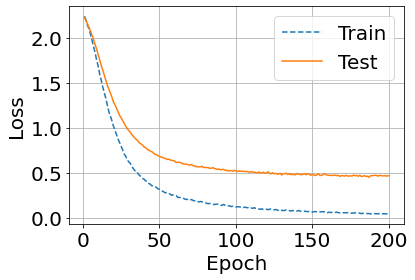

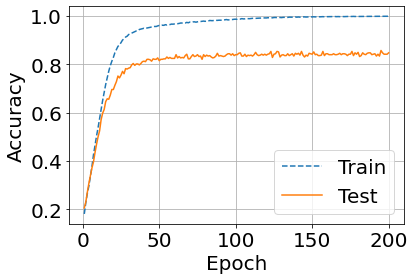

In [12]:
%matplotlib inline

# Plotting loss
f1 = plt.figure()
plt.plot(np.arange(1, num_rounds+1), loss_train_collect, label='Train', linestyle = 'dashed')
plt.plot(np.arange(1, num_rounds+1), loss_test_collect, label='Test', linestyle = 'solid')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()

# Plotting accuracy
f2 = plt.figure()
plt.plot(np.arange(1, num_rounds+1), acc_train_collect, label='Train', linestyle = 'dashed')
plt.plot(np.arange(1, num_rounds+1), acc_test_collect, label='Test', linestyle = 'solid')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()

In [13]:
# GPU usage after computation
if device.type == 'cuda':
    for i in range(0,torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
        print('Memory Usage of device :', i)
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla P100-SXM2-16GB
Memory Usage of device : 0
Allocated: 0.8 GB
Cached:    1.4 GB
Tesla P100-SXM2-16GB
Memory Usage of device : 1
Allocated: 0.8 GB
Cached:    1.4 GB
Tesla P100-SXM2-16GB
Memory Usage of device : 2
Allocated: 0.8 GB
Cached:    1.4 GB
Tesla P100-SXM2-16GB
Memory Usage of device : 3
Allocated: 0.8 GB
Cached:    1.4 GB
